In [1]:
import anndata
import scanpy as sc
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import umap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

adata = sc.read('/tmp/work/RCproject_code/sce_export.h5ad')


/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2024-10-11 17:38:40.630347: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `a

In [7]:
#normalizaiton

gene_expression_data = adata.layers['logcounts']

from sklearn.preprocessing import MinMaxScaler

# Min-max normalization
scaler = MinMaxScaler()
gene_expression_data = scaler.fit_transform(gene_expression_data)


number_samples = adata.shape[0]
number_genes = adata.shape[1]

input_dim = number_genes

encoding_dim = 100 

In [23]:
adata.obs['batch'].value_counts()

batch
GSE190826        104
GSE209746         97
GSE45404_GPL2     42
GSE94104          40
GSE45404_GPL1     38
GSE150082         38
GSE133057         33
GSE145037         31
GSE93375          27
Name: count, dtype: int64

In [10]:
from keras import layers, models
from keras.callbacks import EarlyStopping

# Define a deeper and more sophisticated autoencoder
input_layer = layers.Input(shape=(input_dim,))

# Encoder
encoded = layers.Dense(256, activation=None)(input_layer)
encoded = layers.LeakyReLU()(encoded)
encoded = layers.BatchNormalization()(encoded)
encoded = layers.Dropout(0.3)(encoded)

encoded = layers.Dense(128, activation=None)(encoded)
encoded = layers.LeakyReLU()(encoded)
encoded = layers.BatchNormalization()(encoded)
encoded = layers.Dropout(0.3)(encoded)

encoded = layers.Dense(64, activation=None)(encoded)
encoded = layers.LeakyReLU()(encoded)
encoded = layers.BatchNormalization()(encoded)

encoded = layers.Dense(encoding_dim, activation=None)(encoded)
encoded = layers.LeakyReLU()(encoded)
encoded = layers.BatchNormalization()(encoded)

# Decoder
decoded = layers.Dense(64, activation=None)(encoded)
decoded = layers.LeakyReLU()(decoded)
decoded = layers.BatchNormalization()(decoded)

decoded = layers.Dense(128, activation=None)(decoded)
decoded = layers.LeakyReLU()(decoded)
decoded = layers.BatchNormalization()(decoded)

decoded = layers.Dense(256, activation=None)(decoded)
decoded = layers.LeakyReLU()(decoded)
decoded = layers.BatchNormalization()(decoded)

decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder Model
autoencoder = models.Model(inputs=input_layer, outputs=decoded)
encoder = models.Model(inputs=input_layer, outputs=encoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = autoencoder.fit(gene_expression_data, gene_expression_data,
                          epochs=100,
                          batch_size=32,
                          shuffle=True,
                          validation_split=0.2,
                          callbacks=[early_stopping])

# Get the low-dimensional representation
low_dimensional_representation = encoder.predict(gene_expression_data)

Epoch 1/100
12/12 [==============================] - 3s 77ms/step - loss: 0.0594 - val_loss: 0.0148
Epoch 2/100
12/12 [==============================] - 1s 62ms/step - loss: 0.0121 - val_loss: 0.0148
Epoch 3/100
12/12 [==============================] - 1s 61ms/step - loss: 0.0104 - val_loss: 0.0148
Epoch 4/100
12/12 [==============================] - 1s 62ms/step - loss: 0.0101 - val_loss: 0.0148
Epoch 5/100
12/12 [==============================] - 1s 61ms/step - loss: 0.0095 - val_loss: 0.0148
Epoch 6/100
12/12 [==============================] - 1s 62ms/step - loss: 0.0090 - val_loss: 0.0148
Epoch 7/100
12/12 [==============================] - 1s 62ms/step - loss: 0.0083 - val_loss: 0.0146
Epoch 8/100
12/12 [==============================] - 1s 62ms/step - loss: 0.0084 - val_loss: 0.0141
Epoch 9/100
12/12 [==============================] - 1s 62ms/step - loss: 0.0083 - val_loss: 0.0136
Epoch 10/100
12/12 [==============================] - 1s 63ms/step - loss: 0.0076 - val_loss: 0.0127

In [38]:
import matplotlib.pyplot as plt
import seaborn as sb

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

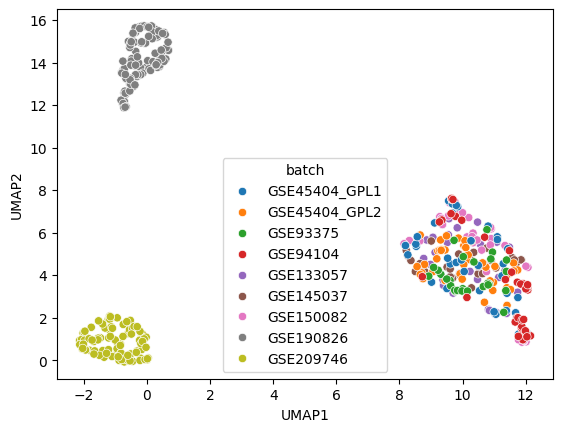

In [42]:
categories =  adata.obs['batch']
# categories =  adata.obs['Platform']

# Step 3: Run UMAP
umap_model = umap.UMAP(n_neighbors=15,   # Controls local vs global structure
                        min_dist=0.1,    # Controls how tightly UMAP packs points together
                        metric='euclidean')  # Distance metric to use
umap_result = umap_model.fit_transform(low_dimensional_representation)


umap_data = {'UMAP1': umap_result[:, 0], 'UMAP2': umap_result[:, 1],'batch':categories}
umap_df = pd.DataFrame(data=umap_data)

sb.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='batch')

# # Step 4: Create a scatter plot with labels
# plt.figure(figsize=(10, 8))

# # Define a colormap
# unique_categories = np.unique(categories)
# cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, len(unique_categories))))

# # Create a scatter plot with color coding based on categories
# scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], 
#                       c=pd.Categorical(categories).codes, alpha=0.5, cmap=cmap)

# # Add a title and labels
# plt.title('UMAP Visualization of Data Matrix with Categories')
# plt.xlabel('UMAP 1')
# plt.ylabel('UMAP 2')

# # Create a legend
# # Create a legend with unique categories
# handles = []
# for i, cat in enumerate(unique_categories):
#     handles.append(plt.Line2D([0], [0], marker='o', color='w', label=cat,
#                                 markerfacecolor=cmap(i), markersize=10))

# # Add legend to the plot
# plt.legend(handles=handles, title="Categories")

# plt.grid()
# plt.show()

In [26]:
adata.obs

,Response,TRG,therapy,Treatment,Platform,batch
GSM3899156_GSE133057,yes,"1,2",CRT,pre,GPL6102,GSE133057
GSM3899157_GSE133057,partial,3,CRT,pre,GPL6102,GSE133057
GSM3899158_GSE133057,yes,"1,2",CRT,pre,GPL6102,GSE133057
GSM3899159_GSE133057,partial,3,CRT,pre,GPL6102,GSE133057
GSM3899160_GSE133057,yes,"1,2",CRT,pre,GPL6102,GSE133057
...,...,...,...,...,...,...
GSM6390458_GSE209746,no,unknown,CRT,pre,GPL16791,GSE209746
GSM6390459_GSE209746,no,unknown,CRT,pre,GPL16791,GSE209746
GSM6390460_GSE209746,no,unknown,CRT,pre,GPL16791,GSE209746
GSM6390461_GSE209746,yes,unknown,CRT,pre,GPL16791,GSE209746


In [24]:
adata.obs['batch'].value_counts()

batch
GSE190826        104
GSE209746         97
GSE45404_GPL2     42
GSE94104          40
GSE45404_GPL1     38
GSE150082         38
GSE133057         33
GSE145037         31
GSE93375          27
Name: count, dtype: int64

In [15]:
# check if any of the low dimensional representations correlate with the response variables

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Convert matrix to DataFrame (if it isn't already)
matrix_df = pd.DataFrame(low_dimensional_representation)
matrix_df.columns = [f"Dim_{i+1}" for i in range(matrix_df.shape[1])]

# Ensure response_vector is a pandas Series
response_vector  = adata.obs['Response']
response_vector = pd.Series(response_vector, name="category")

# Ensure both the matrix and response vector have matching lengths
if len(matrix_df) != len(response_vector):
    raise ValueError("Matrix and response vector lengths do not match!")

anova_results = {}

for column in matrix_df.columns:
    # Create a DataFrame combining the column and the response vector
    df = pd.DataFrame({
        'value': matrix_df[column],
        'category': response_vector
    })
    
    # Drop rows with missing values (if any)
    df.dropna(inplace=True)
    
    if df.empty:
        continue  # Skip if all values are NaN or empty
    
    # Fit an OLS model (ANOVA)
    try:
        model = ols('value ~ C(category)', data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        # Store the p-value for the F-test
        p_value = anova_table["PR(>F)"][0]
        anova_results[column] = p_value
    except Exception as e:
        print(f"Error processing column {column}: {e}")

# Sort and display the significant results
anova_results = {k: v for k, v in sorted(anova_results.items(), key=lambda item: item[1])}
significant_columns = [col for col, p in anova_results.items() if p < 0.05]

print("Significant columns:", significant_columns)

Significant columns: []


In [16]:
low_dimensional_representation.shape

(450, 100)

In [19]:
np.unique(adata.obs['Platform'])

array(['GPL13497', 'GPL14951', 'GPL15207', 'GPL16791', 'GPL20301',
       'GPL28140', 'GPL4133', 'GPL570', 'GPL6102'], dtype=object)

In [18]:
adata.obs

,Response,TRG,therapy,Treatment,Platform,batch
GSM3899156_GSE133057,yes,"1,2",CRT,pre,GPL6102,GSE133057
GSM3899157_GSE133057,partial,3,CRT,pre,GPL6102,GSE133057
GSM3899158_GSE133057,yes,"1,2",CRT,pre,GPL6102,GSE133057
GSM3899159_GSE133057,partial,3,CRT,pre,GPL6102,GSE133057
GSM3899160_GSE133057,yes,"1,2",CRT,pre,GPL6102,GSE133057
...,...,...,...,...,...,...
GSM6390458_GSE209746,no,unknown,CRT,pre,GPL16791,GSE209746
GSM6390459_GSE209746,no,unknown,CRT,pre,GPL16791,GSE209746
GSM6390460_GSE209746,no,unknown,CRT,pre,GPL16791,GSE209746
GSM6390461_GSE209746,yes,unknown,CRT,pre,GPL16791,GSE209746


In [28]:
low_dimensional_representation.shape

(450, 100)